In [1]:
import numpy as np
import matplotlib.pyplot as plt
import fenics as fe

import sys
sys.path.insert(0, "../src")

from swe import ShallowOne, ShallowOneLinear

control = dict(nx=500, dt=2., theta=0.6, simulation="tidal_flow")

[1000.         1571.42857143 2142.85714286 2714.28571429 3285.71428571
 3857.14285714 4428.57142857 5000.        ]
[1.00000000e+00 3.72759372e+00 1.38949549e+01 5.17947468e+01
 1.93069773e+02 7.19685673e+02 2.68269580e+03 1.00000000e+04]
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.


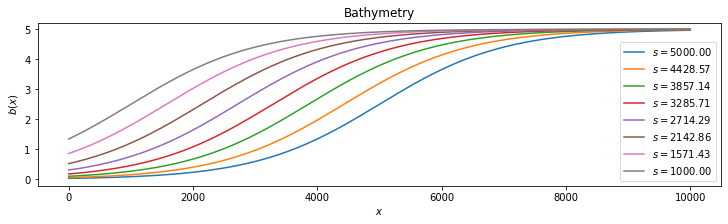

In [2]:
# set up bump/dissipation args
shore_starts = np.linspace(1000., 5000., num=8)
nus = np.logspace(0., 4., num=8)
print(shore_starts)
print(nus)

shore_model_args = [
    (shore_start, 1., False) for shore_start in shore_starts]
shore_linear_model_args = [
    (shore_start, 1., True) for shore_start in shore_starts]
damped_model_args = [(1000., nu, False) for nu in nus]

# now plot the different bathymetries
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10, 3))
for s in shore_starts[::-1]:
    swe = ShallowOne(control=control, 
                     params=dict(nu=1.,
                                 shore_start=s, shore_height=2.5,
                                 bump_height=0., bump_centre=1000., bump_width=400))
    fe.plot(30 - swe.H, label=fr"$s = {s:.2f}$")
    
ax.set_title("Bathymetry")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$b(x)$")
ax.legend()
plt.show()

In [3]:
fe.set_log_level(50)

def run_model(shore_start, nu, linear):
    if linear:
        swe = ShallowOneLinear(control=control,
                               params=dict(nu=nu,
                                           shore_start=shore_start, shore_height=2.5,
                                           bump_height=0., bump_centre=1000., bump_width=400))
    else:
        swe = ShallowOne(control=control, 
                         params=dict(nu=nu,
                                     shore_start=shore_start, shore_height=2.5,
                                     bump_height=0., bump_centre=1000., bump_width=400))
        
    t_final = 60 * 60 * 12.
    nt = int((t_final) / swe.dt)

    i_save = 0
    nt_skip = 5  # store every 10 s
    nt_save = len([i for i in range(nt) if i % nt_skip == 0])

    t_out = np.zeros((nt_save, ))
    u_out = np.zeros((nt_save, len(swe.mesh.coordinates())))
    h_out = np.zeros((nt_save, len(swe.mesh.coordinates())))

    t = 0.
    from tqdm import tqdm
    for i in tqdm(range(nt)):
        t += swe.dt
        swe.solve(t)

        if i % nt_skip == 0:
            t_out[i_save] = t
            u, h = swe.du.split()
            u_out[i_save, :] = u.compute_vertex_values()
            h_out[i_save, :] = h.compute_vertex_values()

            i_save += 1
    
    return [t_out, u_out, h_out]

In [4]:
ref_model = run_model(2000., 1., False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21600/21600 [01:50<00:00, 195.25it/s]


In [5]:
from multiprocessing import Pool

p = Pool(17)
out_shore = p.starmap_async(run_model, shore_model_args)
out_linear_shore = p.starmap_async(run_model, shore_linear_model_args)
out_damped = p.starmap(run_model, damped_model_args)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21600/21600 [02:15<00:00, 158.98it/s]


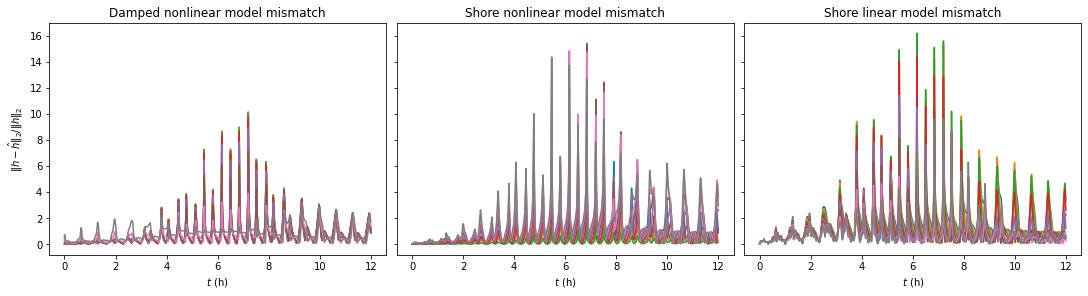

In [7]:
norm = np.linalg.norm
t_out = out_damped[0][0]

fig, axs = plt.subplots(1, 3, figsize=(15, 4), 
                        constrained_layout=True, sharey=True)

for model in out_damped:
    axs[0].plot(t_out / 3600, 
                norm(ref_model[2] - model[2], axis=1) / norm(ref_model[2], axis=1))
axs[0].set_ylabel(r"$\Vert h - \hat{h} \Vert_2 / \Vert h \Vert_2$")
axs[0].set_title("Damped nonlinear model mismatch")

for model in out_shore.get():
    axs[1].plot(t_out / 3600, 
                norm(ref_model[2] - model[2], axis=1) / norm(ref_model[2], axis=1))
axs[1].set_title("Shore nonlinear model mismatch")

for model in out_linear_shore.get():
    axs[2].plot(t_out/ 3600, 
                norm(ref_model[2] - model[2], axis=1) / norm(ref_model[2], axis=1))
axs[2].set_title("Shore linear model mismatch")
for ax in axs:
    ax.set_xlabel(r"$t$ (h)")
plt.show()